# Data sourcing

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
import matplotlib
%matplotlib inline
import numpy as np
import pandas as pd

**Goal 1:** get song data from a Spotify dump CSV.

## 1️⃣ CSV

In [32]:
!tree

.
├── __pycache__
│   ├── music.cpython-310.pyc
│   └── music.cpython-38.pyc
├── bad-import-example
│   ├── __pycache__
│   │   ├── bad_import_lib.cpython-38.pyc
│   │   └── good_import_lib.cpython-38.pyc
│   ├── bad_import_lib.py
│   ├── good_import_lib.py
│   └── main.py
├── data
│   ├── music.sqlite
│   └── spotify_2017.csv
├── data-sourcing-ref.ipynb
├── data-sourcing.ipynb
├── music.py
├── recap
│   ├── README.md
│   ├── Recap.ipynb
│   └── books.csv
└── recap-ref
    ├── README.md
    ├── Recap.ipynb
    └── books.csv

7 directories, 18 files


In [33]:
tracks_df = pd.read_csv('data/spotify_2017.csv')

In [34]:
tracks_df[['name', 'artists']].head()

,name,artists
0,Shape of You,Ed Sheeran
1,Despacito - Remix,Luis Fonsi
2,Despacito (Featuring Daddy Yankee),Luis Fonsi
3,Something Just Like This,The Chainsmokers
4,I'm the One,DJ Khaled


In [35]:
tracks_df.info
tracks_df.shape

(100, 16)

**Goal 2:** fetch lyrics and add them as new column of our dataframe track_df
Where could we get that data from? 

## 2️⃣ API

In [36]:
from music import fetch_lyrics

In [37]:
%%time
for index, row in tracks_df.iterrows():
    tracks_df.loc[index, 'lyrics'] = fetch_lyrics(row['artists'], row['name'])

CPU times: user 2.4 s, sys: 163 ms, total: 2.57 s
Wall time: 1min 44s


In [38]:
tracks_df.head(10)

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,lyrics
0,7qiZfU4dY1lWllzX7mPBI,Shape of You,Ed Sheeran,0.825,0.652,1.0,-3.183,0.0,0.0802,0.581000,0.000000,0.0931,0.9310,95.977,233713.0,4.0,The club isn't the best place to find a lover\...
1,5CtI0qwDJkDQGwXD1H1cL,Despacito - Remix,Luis Fonsi,0.694,0.815,2.0,-4.328,1.0,0.1200,0.229000,0.000000,0.0924,0.8130,88.931,228827.0,4.0,No lyrics
2,4aWmUDTfIPGksMNLV2rQP,Despacito (Featuring Daddy Yankee),Luis Fonsi,0.660,0.786,2.0,-4.757,1.0,0.1700,0.209000,0.000000,0.1120,0.8460,177.833,228200.0,4.0,No lyrics
3,6RUKPb4LETWmmr3iAEQkt,Something Just Like This,The Chainsmokers,0.617,0.635,11.0,-6.769,0.0,0.0317,0.049800,0.000014,0.1640,0.4460,103.019,247160.0,4.0,I've been reading books of old\nThe legends an...
4,3DXncPQOG4VBw3QHh3S81,I'm the One,DJ Khaled,0.609,0.668,7.0,-4.284,1.0,0.0367,0.055200,0.000000,0.1670,0.8110,80.924,288600.0,4.0,[DJ Khaled:]\nWe The Best Music\nAnother One!\...
5,7KXjTSCq5nL1LoYtL7XAw,HUMBLE.,Kendrick Lamar,0.904,0.611,1.0,-6.842,0.0,0.0888,0.000259,0.000020,0.0976,0.4000,150.020,177000.0,4.0,"[Music video version:] Wicked or weakness, you..."
6,3eR23VReFzcdmS7TYCrhC,It Ain't Me (with Selena Gomez),Kygo,0.640,0.533,0.0,-6.596,1.0,0.0706,0.119000,0.000000,0.0864,0.5150,99.968,220781.0,4.0,No lyrics
7,3B54sVLJ402zGa6Xm4YGN,Unforgettable,French Montana,0.726,0.769,6.0,-5.043,1.0,0.1230,0.029300,0.010100,0.1040,0.7330,97.985,233902.0,4.0,"[Swae Lee:]\nIt's not good enough for me, sinc..."
8,0KKkJNfGyhkQ5aFogxQAP,That's What I Like,Bruno Mars,0.853,0.560,1.0,-4.961,1.0,0.0406,0.013000,0.000000,0.0944,0.8600,134.066,206693.0,4.0,"Ay, ay, ay\nI got a condo in Manhattan\nBaby g..."
9,3NdDpSvN911VPGivFlV5d,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,0.735,0.451,0.0,-8.374,1.0,0.0585,0.063100,0.000013,0.3250,0.0862,117.973,245200.0,4.0,No lyrics


**Goal 3:** add the amount of LastFM listener per song from a LastFM DB dump

## 3️⃣ SQL

In [39]:
query = """
    SELECT ai.artist_mb, p.listeners_lastfm
    FROM artist_info ai 
    JOIN popularity p ON ai.mbid = p.mbid
    WHERE p.listeners_lastfm >= ?
"""

In [40]:
limit = "500000"

In [41]:
import sqlite3

In [42]:
conn = sqlite3.connect('data/music.sqlite')

In [43]:
# c = conn.cursor()
# c.execute(query)
# data = c.fetchall()
# list(data)[:2]

In [44]:
listen_df = pd.read_sql(query, conn, params=(limit,))
listen_df

,artist_mb,listeners_lastfm
0,Coldplay,5381567.0
1,Radiohead,4732528.0
2,Red Hot Chili Peppers,4620835.0
3,Rihanna,4558193.0
4,Eminem,4517997.0
...,...,...
1847,Future Islands,500380.0
1848,Bobby Helms,500364.0
1849,Inner Circle,500335.0
1850,War,500332.0


In [45]:
tracks_df = tracks_df.merge(
    listen_df,
    left_on= 'artists',
    right_on='artist_mb',
    how='left'
)

In [46]:
tracks_df

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,lyrics,artist_mb,listeners_lastfm
0,7qiZfU4dY1lWllzX7mPBI,Shape of You,Ed Sheeran,0.825,0.652,1.0,-3.183,0.0,0.0802,0.5810,0.000000,0.0931,0.9310,95.977,233713.0,4.0,The club isn't the best place to find a lover\...,Ed Sheeran,1620379.0
1,5CtI0qwDJkDQGwXD1H1cL,Despacito - Remix,Luis Fonsi,0.694,0.815,2.0,-4.328,1.0,0.1200,0.2290,0.000000,0.0924,0.8130,88.931,228827.0,4.0,No lyrics,NaN,NaN
2,4aWmUDTfIPGksMNLV2rQP,Despacito (Featuring Daddy Yankee),Luis Fonsi,0.660,0.786,2.0,-4.757,1.0,0.1700,0.2090,0.000000,0.1120,0.8460,177.833,228200.0,4.0,No lyrics,NaN,NaN
3,6RUKPb4LETWmmr3iAEQkt,Something Just Like This,The Chainsmokers,0.617,0.635,11.0,-6.769,0.0,0.0317,0.0498,0.000014,0.1640,0.4460,103.019,247160.0,4.0,I've been reading books of old\nThe legends an...,The Chainsmokers,794664.0
4,3DXncPQOG4VBw3QHh3S81,I'm the One,DJ Khaled,0.609,0.668,7.0,-4.284,1.0,0.0367,0.0552,0.000000,0.1670,0.8110,80.924,288600.0,4.0,[DJ Khaled:]\nWe The Best Music\nAnother One!\...,DJ Khaled,1160535.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1PSBzsahR2AKwLJgx8ehB,Bad Things (with Camila Cabello),Machine Gun Kelly,0.675,0.690,2.0,-4.761,1.0,0.1320,0.2100,0.000000,0.2870,0.2720,137.817,239293.0,4.0,I can't stop thinkin'\nThinking 'bout sinkin'\...,NaN,NaN
96,0QsvXIfqM0zZoerQfsI9l,Don't Let Me Down,The Chainsmokers,0.542,0.859,11.0,-5.651,1.0,0.1970,0.1600,0.004660,0.1370,0.4030,159.797,208053.0,4.0,No lyrics,The Chainsmokers,794664.0
97,7mldq42yDuxiUNn08nvzH,Body Like A Back Road,Sam Hunt,0.731,0.469,5.0,-7.226,1.0,0.0326,0.4630,0.000001,0.1030,0.6310,98.963,165387.0,4.0,Folks said that you found someone new\nTo do t...,NaN,NaN
98,7i2DJ88J7jQ8K7zqFX2fW,Now Or Never,Halsey,0.658,0.588,6.0,-4.902,0.0,0.0367,0.1050,0.000001,0.1250,0.4340,110.075,214802.0,4.0,No lyrics,Halsey,564334.0


**Goal 4:** add another track popularity info from BigQuery ListenBrainz DB

## 4️⃣ Google BigQuery

In [47]:
!pip install --quiet pandas-gbq

In [55]:
import pandas_gbq

In [56]:
query = """
    SELECT artist_name, COUNT(artist_name) artist_count
    FROM `lwt-data-lectures.listenbrainz.listen` 
    WHERE listened_at BETWEEN '2017-01-01' AND '2018-01-01'
    GROUP BY artist_name
    HAVING artist_count > 1000
    ORDER BY artist_count DESC
    LIMIT 1000
"""

In [57]:
project_id='lwt-data-lectures'

In [58]:
musicbrainz_df = pandas_gbq.read_gbq(query, project_id=project_id)
musicbrainz_df

GenericGBQException: Reason: 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/lwt-data-lectures/jobs?prettyPrint=false: Access Denied: Project lwt-data-lectures: User does not have bigquery.jobs.create permission in project lwt-data-lectures.

(job ID: 44a589dd-167a-4e1d-8254-ff75175ffdba)

                -----Query Job SQL Follows-----                 

    |    .    |    .    |    .    |    .    |    .    |
   1:
   2:    SELECT artist_name, COUNT(artist_name) artist_count
   3:    FROM `lwt-data-lectures.listenbrainz.listen` 
   4:    WHERE listened_at BETWEEN '2017-01-01' AND '2018-01-01'
   5:    GROUP BY artist_name
   6:    HAVING artist_count > 1000
   7:    ORDER BY artist_count DESC
   8:    LIMIT 1000
    |    .    |    .    |    .    |    .    |    .    |

**Last Goal:** get the artist bday from Wikipedia!

## 5️⃣ Scraping

In [59]:
import requests
from bs4 import BeautifulSoup

In [67]:
def bday_scrape(name):
    try:
        url = f"https://en.wikipedia.org/wiki/{name.replace(' ', '_')}"
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        return soup.find("span", class_='bday').text
    except:
        return 'N/A'

In [70]:
for index, row in tracks_df.iterrows():
    bday = bday_scrape(row['artists'])
    tracks_df.loc[index, 'bday'] = bday
            

In [71]:
tracks_df.head(10)

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,lyrics,artist_mb,listeners_lastfm,bday
0,7qiZfU4dY1lWllzX7mPBI,Shape of You,Ed Sheeran,0.825,0.652,1.0,-3.183,0.0,0.0802,0.581000,0.000000,0.0931,0.9310,95.977,233713.0,4.0,The club isn't the best place to find a lover\...,Ed Sheeran,1620379.0,1991-02-17
1,5CtI0qwDJkDQGwXD1H1cL,Despacito - Remix,Luis Fonsi,0.694,0.815,2.0,-4.328,1.0,0.1200,0.229000,0.000000,0.0924,0.8130,88.931,228827.0,4.0,No lyrics,NaN,NaN,1978-04-15
2,4aWmUDTfIPGksMNLV2rQP,Despacito (Featuring Daddy Yankee),Luis Fonsi,0.660,0.786,2.0,-4.757,1.0,0.1700,0.209000,0.000000,0.1120,0.8460,177.833,228200.0,4.0,No lyrics,NaN,NaN,1978-04-15
3,6RUKPb4LETWmmr3iAEQkt,Something Just Like This,The Chainsmokers,0.617,0.635,11.0,-6.769,0.0,0.0317,0.049800,0.000014,0.1640,0.4460,103.019,247160.0,4.0,I've been reading books of old\nThe legends an...,The Chainsmokers,794664.0,1985-05-16
4,3DXncPQOG4VBw3QHh3S81,I'm the One,DJ Khaled,0.609,0.668,7.0,-4.284,1.0,0.0367,0.055200,0.000000,0.1670,0.8110,80.924,288600.0,4.0,[DJ Khaled:]\nWe The Best Music\nAnother One!\...,DJ Khaled,1160535.0,1975-11-26
5,7KXjTSCq5nL1LoYtL7XAw,HUMBLE.,Kendrick Lamar,0.904,0.611,1.0,-6.842,0.0,0.0888,0.000259,0.000020,0.0976,0.4000,150.020,177000.0,4.0,"[Music video version:] Wicked or weakness, you...",Kendrick Lamar,1472390.0,1987-06-17
6,3eR23VReFzcdmS7TYCrhC,It Ain't Me (with Selena Gomez),Kygo,0.640,0.533,0.0,-6.596,1.0,0.0706,0.119000,0.000000,0.0864,0.5150,99.968,220781.0,4.0,No lyrics,Kygo,707859.0,1991-09-11
7,3B54sVLJ402zGa6Xm4YGN,Unforgettable,French Montana,0.726,0.769,6.0,-5.043,1.0,0.1230,0.029300,0.010100,0.1040,0.7330,97.985,233902.0,4.0,"[Swae Lee:]\nIt's not good enough for me, sinc...",French Montana,616457.0,1984-11-09
8,0KKkJNfGyhkQ5aFogxQAP,That's What I Like,Bruno Mars,0.853,0.560,1.0,-4.961,1.0,0.0406,0.013000,0.000000,0.0944,0.8600,134.066,206693.0,4.0,"Ay, ay, ay\nI got a condo in Manhattan\nBaby g...",Bruno Mars,1841782.0,1985-10-08
9,3NdDpSvN911VPGivFlV5d,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,0.735,0.451,0.0,-8.374,1.0,0.0585,0.063100,0.000013,0.3250,0.0862,117.973,245200.0,4.0,No lyrics,NaN,NaN,N/A


<AxesSubplot:>

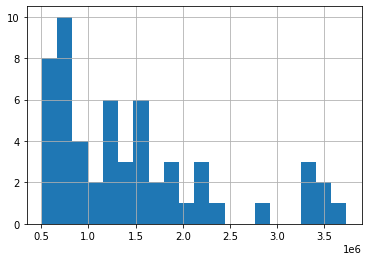

In [73]:
tracks_df["listeners_lastfm"].hist(bins=20)

In [74]:
import re
pattern = r'\d{4}-\d{2}-\d{2}'
# Find only the rows that have valid birthdays
only_bdays = tracks_df[tracks_df["bday"].str.match(pattern)].copy()
# Convert to a datetime format
tracks_df["birthday"] = pd.to_datetime(only_bdays["bday"])

<AxesSubplot:xlabel='birthday', ylabel='listeners_lastfm'>

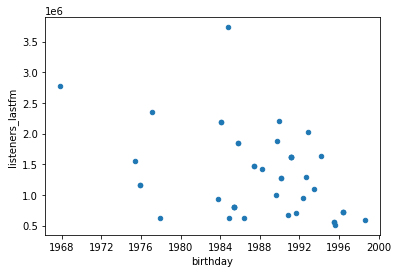

In [75]:
tracks_df.plot.scatter("birthday", "listeners_lastfm")